In [1]:
# tisztitott verzio behivasa!!!!! tract_df-ről census leszedni és tisztitottat rámergelni!!!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# TODO B delete some of these



import geopandas as gpd
import seaborn as sns
import networkx as nx

import scipy
import csv

import matplotlib.cm as cm

import json
import community as community_louvain
from copy import deepcopy
# from modularity_maximization.utils import get_modularity

from itertools import product
import networkx.algorithms.community as nx_comm
from scipy.spatial.distance import pdist, squareform

from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame

import math
from time import time

import matplotlib.lines as lines

## %matplotlib inline
%pylab inline
# KERDES - javitani B

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time', 'product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Data

In [2]:
# census data IN
#census = pd.read_csv("../data/censusdata_top50_2012.csv")
#census_2 = pd.read_csv("../data/censusdata_top50_2017.csv")

# three networks - data IN
mobility = pd.read_csv("../data/usageousers_city_mobility_CT_networks.rpt.gz") ## basis of position and node importance calculations
follow_hh = pd.read_csv("../data/usageousers_city_follower_CT_HH_networks.rpt.gz")
follow_hh = follow_hh.rename(columns={"tract_home.1": "tract_home_1"})

# census tract name -> cbsacode
cbsacode = pd.read_csv("../data/cbsacode_shortname_tracts.csv",sep=";", index_col=0)
cbsacode['clean_name'] = cbsacode["short_name"].map(lambda s: s.split("/")[0].replace(' ','_').replace('.','').lower())

tract_df = pd.read_csv('../data/network_properties.csv')

# reading geojson data, converting it to geopandas dataframe
tract_geoms = gpd.GeoDataFrame.from_features(
    [json.loads(e.strip('\n')) for e in open('../data/censustract_geoms_top50.geojson').readlines()]
)

# Cartesian coordinate projection of tract centroids
tract_geoms['centroid'] = tract_geoms['geometry'].centroid
tract_center_dict = tract_geoms\
    .set_geometry('centroid',crs={'init':'epsg:4326'})\
    .to_crs({'init':'epsg:3785'})\
    .set_index('full_geoid')['centroid'].map(lambda p: p.coords[0]).to_dict()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [3]:
city_l = list(cbsacode['clean_name'].unique())

In [4]:
# HIBAS AZ ADATBAZIS --> vannak benne duplikátumok
algorithm_type = 'ms'
g_type = 'mob'
len(list(tract_df[(tract_df['algorithm_type'] == algorithm_type) & (tract_df['g_type'] == g_type)]['geoid'])) - len(set(tract_df[(tract_df['algorithm_type'] == algorithm_type) & (tract_df['g_type'] == g_type)]['geoid']))

27

In [5]:
# calculate proportions - mean tract population is not the same among communities

# for 2012
tract_df['educ_bach_p_1'] = tract_df['education_bachelor_1']/tract_df['population_1']
tract_df['educ_total_p_1'] = tract_df['education_total_1']/tract_df['population_1']
tract_df['white_p_1'] = tract_df['white_1']/tract_df['population_1']
tract_df['black_p_1'] = tract_df['black_1']/tract_df['population_1']
tract_df['native_p_1'] = tract_df['native_1']/tract_df['population_1']
tract_df['asian_p_1'] = tract_df['asian_1']/tract_df['population_1']

# for 2017
tract_df['educ_bach_p_2'] = tract_df['education_bachelor_2']/tract_df['population_2']
tract_df['educ_total_p_2'] = tract_df['education_total_2']/tract_df['population_2']
tract_df['white_p_2'] = tract_df['white_2']/tract_df['population_2']
tract_df['black_p_2'] = tract_df['black_2']/tract_df['population_2']
tract_df['native_p_2'] = tract_df['native_2']/tract_df['population_2']
tract_df['asian_p_2'] = tract_df['asian_2']/tract_df['population_2']

In [6]:
tract_once = tract_df[tract_df['algorithm_type'] == 'mg']
network_df = deepcopy(tract_once.groupby(['city','g_type'])['educ_bach_p_1','white_p_1','black_p_1','native_p_1','asian_p_1', 'income_1', 
                                                          'educ_bach_p_2','white_p_2','black_p_2','native_p_2','asian_p_2', 'income_2'].mean().reset_index())

# every tract is counted twice - once for each algorithm_type -- solved
network_df = network_df.rename(columns = {'educ_bach_p_1' : 'educ_bach_p_avg_1','white_p_1' : 'white_p_avg_1', 'black_p_1' : 'black_p_avg_1', 'native_p_1' : 'native_p_avg_1', 'asian_p_1' : 'asian_p_avg_1', 'income_1' : 'income_avg_1',
                                          'educ_bach_p_2' : 'educ_bach_p_avg_2','white_p_2' : 'white_p_avg_2', 'black_p_2' : 'black_p_avg_2', 'native_p_2' : 'native_p_avg_2', 'asian_p_2' : 'asian_p_avg_2', 'income_2' : 'income_avg_2'})

In [7]:
tract_df = pd.merge(tract_df, network_df, how = 'left', on = ['city', 'g_type'])

In [8]:
tract_df['educ_bach_p_diff_1'] = tract_df['educ_bach_p_1'] - tract_df['educ_bach_p_avg_1']
tract_df['white_p_diff_1'] = tract_df['white_p_1'] - tract_df['white_p_avg_1']
tract_df['black_p_diff_1'] = tract_df['black_p_1'] - tract_df['black_p_avg_1']
tract_df['native_p_diff_1'] = tract_df['native_p_1'] - tract_df['native_p_avg_1']
tract_df['asian_p_diff_1'] = tract_df['asian_p_1'] - tract_df['asian_p_avg_1']
tract_df['income_diff_1'] = tract_df['income_1'] - tract_df['income_avg_1']

## Colors

In [9]:
color_mob = '#2d004b'
color_mob_2 = '#8073ac'
color_fol_hh = '#00441b'
color_fol_hh_2 = '#5aae61'

# Analysis

In [ ]:
## Amikor a network_df-et (vagy a network_df_2-t csinálom hogyan csináljam a groupby-t?? Az algorithm_type kell bele?)

In [10]:
network_df_2 = deepcopy(tract_df.groupby(['city','algorithm_type','g_type']))[
    'tracts_in_network', 'S_cons'
    ].max().reset_index()
network_df_2['S_plus_1'] = network_df_2['S_cons'] + 1 # preparation to plot, S_cons indexed from 0
network_df_2 = network_df_2.rename(columns = {'S_cons' : 'S_cons_max', 'S_plus_1' : 'S_plus_1_max'})

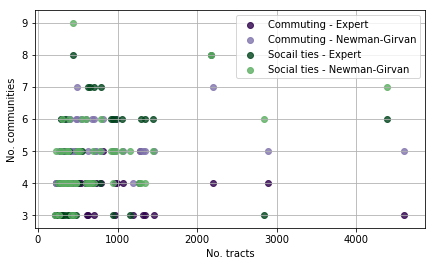

In [11]:
network_df_2_ms_mob = deepcopy(network_df_2[(network_df_2['algorithm_type'] == 'ms') & (network_df_2['g_type'] == 'mob')])
network_df_2_mgn_mob = deepcopy(network_df_2[(network_df_2['algorithm_type'] == 'mgn') & (network_df_2['g_type'] == 'mob')])
network_df_2_ms_fol_hh = deepcopy(network_df_2[(network_df_2['algorithm_type'] == 'ms') & (network_df_2['g_type'] == 'fol_hh')])
network_df_2_mgn_fol_hh = deepcopy(network_df_2[(network_df_2['algorithm_type'] == 'mgn') & (network_df_2['g_type'] == 'fol_hh')])


fig, ax = plt.subplots(figsize = (7,4))

ax.scatter(network_df_2_ms_mob['tracts_in_network'], network_df_2_ms_mob['S_plus_1_max'], c = color_mob, alpha = 0.8, label = 'Commuting - Expert')
ax.scatter(network_df_2_mgn_mob['tracts_in_network'], network_df_2_mgn_mob['S_plus_1_max'], c = color_mob_2, alpha = 0.8, label = 'Commuting - Newman-Girvan')
ax.scatter(network_df_2_ms_fol_hh['tracts_in_network'], network_df_2_ms_fol_hh['S_plus_1_max'], c = color_fol_hh, alpha = 0.8, label = 'Socail ties - Expert')
ax.scatter(network_df_2_mgn_fol_hh['tracts_in_network'], network_df_2_mgn_fol_hh['S_plus_1_max'], c = color_fol_hh_2, alpha = 0.8, label = 'Social ties - Newman-Girvan')

#ax.legend()
ax.set_xlabel('No. tracts')
ax.set_ylabel('No. communities')
ax.legend()
ax.grid(True)

plt.show()

# Communities contribution to modularity

In [12]:
# copied from Spatial_modularity_pooled notebook
def create_graphs(city, g_type):
    """
    For a given city name, it generates a mobility and follower (home-home) graph.
    
    e.g. g_mob, g_fol_hh = create_graphs("Boston")
    
    It uses the previously loaded `mobility` and `follow_hh` pandas.DataFrames, in which
    the edges are listed for every city.
    
    Parameters:
    -----------
    city : str
        name of the city, see cbsacode dataframe -> clean_name
        
    g_type : str
        either "mob" as mobility or "fol_hh" as follow_hh 
        selects the type of graph to return
        
    Returns:
    --------
    
    g : networkx.Graph
        weighted undirected graph based on city name and g_type (e.g. follow_hh graph of Boston)
        
    """
    # city cbsacode based on name
    city_code = cbsacode[cbsacode.clean_name == city].iloc[0].cbsacode
    
    # select graph type
    if g_type == "mob":
        # filtering large dataframes for the given city code
        mob_df = deepcopy(mobility[(mobility["cbsacode"] == city_code)&(mobility["tract_home"]!=mobility["tract_work"])])

        # create graphs
        # create empty graphs
        g_mob = nx.DiGraph() # mobility graph - weights are counts

        # fill in the networks with data
        mob_df['w_edges'] = list(zip(mob_df.tract_home,mob_df.tract_work,mob_df.cnt))
        g_mob.add_weighted_edges_from(mob_df["w_edges"], weight='cnt')

        # ineffective and slow!
        for e in g_mob.edges():
            r = (e[1],e[0])

            if r in g_mob.edges():
                c1 = g_mob.edges[e]['cnt']
                c2 = g_mob.edges[r]['cnt']

                g_mob.edges[e]['cnt'] = c1 + c2
                g_mob.edges[r]['cnt'] = c1 + c2

        # then let's convert the mobility graph to udirected
        g_mob = g_mob.to_undirected()

        g = g_mob
        
    elif g_type == "fol_hh":            
        # filtering large dataframes for the given city code
        fol_hh_df = deepcopy(follow_hh[(follow_hh["cbsacode"] == city_code)&(follow_hh["tract_home"]!=follow_hh["tract_home_1"])])

        # create graphs
        # create empty graphs
        g_fol_hh = nx.Graph() # follow home-home graph - weights are counts

        # this is an undirected graph already in the dataframe
        fol_hh_df['w_edges'] = list(zip(fol_hh_df.tract_home,fol_hh_df.tract_home_1,fol_hh_df.cnt))
        g_fol_hh.add_weighted_edges_from(fol_hh_df["w_edges"], weight='cnt')
        
        g = g_fol_hh
        
    # TODO --> DONE
    # check data - if all nodes of the graph are in the tract_geom dataframe
    # e.g. in create_graphs()
    # if someone's not there, that is data error, print the tract_id, and leave the node out of the graph G
    # only after this should we calculate the Expert input data    
    while not set(g.nodes).issubset(set(tract_geoms.full_geoid)): # KERDES: ezt hogyan ellenőrizzem le?
        print('DATA ERROR. Node do(es) not have corresponding geodata, so dropped.')
        print('Dropped node(s):')
        ####nodes_to_drop = set(g.nodes).difference(set(tract_geoms.full_geoid))
        ####g.remove_nodes_from(nodes_to_drop)
    return g

In [13]:
# copied from Spatial_modularity_pooled notebook
def SpaMod(A,D,N,binnumber): # binnumber instead of b = binsize
    """
    Function that calculates the matrix for the clustering 
    based on spatial null model a la Expert.
    
    Parameters:
    -----------
    
    A : scipy.sparse.csr.csr_matrix
        adjacency matrix
    D : numpy.ndarray
        Distance matrix between the nodes
    N : numpy.matrix
        a measure of the importance of a node
        the number of users living(home-location) in the given tract
    binnumber : int
        number of distance bins (used in the estimation of the deterrence function)
    Returns:
    --------
    
    KERDES - ellenorizni
    ModularitySpa : 
    ModularityGN :
    """
    
    #tic = time()
    
    #print("Beginning of modularity function...");   
    # felesleges?? KERDES -- symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
    A = A + A.T ### KERDES KELL-e?? TODO ATGONDOLNI? ILLETVE LE KELL-e osztani 2-vel   / 2     
    b = D.max()/(binnumber-1) # MODIFIED
    
    # deterrence function
    det, detbins = np.histogram(
        D.flatten(),
        range = (0, np.ceil(D.max()/b)*b), # JAVITAS
        weights = np.array(A.todense()).flatten(), 
        bins=int(np.ceil(D.max()/b))
    )
    normadet, _ = np.histogram(
        D.flatten(), 
        range = (0, np.ceil(D.max()/b)*b),
        weights = np.array(N*N.T).flatten(), 
        bins=int(np.ceil(D.max()/b))
    )
    det = det / normadet
    det[np.isnan(det)] = 0
    
    #toc = time()
    #print("Done.","%.2f" % (toc-tic))
    
    #tic = toc
    
    #print("Null modell...")
    
    # copmutation of the randomised correlations (preserving space), spatial
    # null-model
    nullmodelSpa = det[np.digitize(D,detbins,right=True)-1]
    
    #toc = time()
    #print("Done.","%.2f" % (toc-tic))
    
    #tic = toc
    
    #print("Modularity calc...")
    
    # the modularity matrix for the spatial null-model
    ModularitySpa=A-np.multiply(N*N.T, nullmodelSpa*A.sum())/(np.multiply(N*N.T,nullmodelSpa).sum())
    szamlalo = np.multiply(N*N.T, nullmodelSpa*A.sum())
    nevezo = np.multiply(N*N.T,nullmodelSpa).sum()
    
    # the modularity matrix for the GN null-model
    degree = degree = A.sum(axis=0) # JAVITVA np.squeeze(np.asarray(A.sum(axis=0))) # degree or strength of nodes || asarry for further usage
    nullmodelGN = degree.T*degree/degree.sum() # Newman-Girvan null-model
    ModularityGN = A - nullmodelGN
    
    #toc = time()
    #print("Done.","%.2f" % (toc-tic))
    
    return ModularitySpa, ModularityGN # KERDES UTOLAG: EZ AZT ADJA MEG, HOGY ADOTT KÉT CSÚCS KÖZÖTT MENNYIVEL TÖBB ÉL VAN A VÁRTNÁL??
# KERDES FOLYT.: EGY KLASZTEREZÉS MODULARITÁSÁT ÚGY KAPOM MEG EBBŐL, HOGY ÖSSZEADOM AZON ELEMEIT, AMIK MINDKÉT CSÚCSA UGYANAHHOZ A COMMUNITYHEZ TARTOZIK, MAJD EOLSZTOM 2M-MEL (2*m = 2-szer total weight of the network = 2*szum(A)/2 = szum(A)

In [14]:
def community_modularity(city, g_type):
    """
    Calculates how much a certain community contributes to the overall modularity.
    
    Uses the create_function and SpaMod functions.
    
    Parameters:
    -----------
    city : str
        as in cbsacode.clean_name ex: 'salt_lake_city'
    
    g_type : str
        'mob' or 'fol_hh' as mobility (commuting) or follower home-home (social ties)
        
    Returns:
    ---------
    
    pandas.DataFrame with measure of how much a given community contributed to the overall modularity of the given network's
    partitioning with for the two algorithms.

    """
    
    G = create_graphs(city, g_type) # corresponding weighted undirected graph
    
    # Dataprep for Expert algorithm
    A = nx.adjacency_matrix(G)
    coords = np.array([tract_center_dict[n] for n in G.nodes()])
    d = pdist(coords)
    D = squareform(pdist(coords))
    tract_outdeg_mob = mobility.groupby('tract_home')[['cnt']].sum()
    N = np.matrix([tract_outdeg_mob.loc[k].iloc[0] for k in G.nodes()]).T

    Ms,Mgn = SpaMod(A,D,N,200)
    
    
    mod_df = pd.DataFrame(columns=['city', 'algorithm_type', 'g_type', 'S', 'modularity_S'])
    
    for (modularity, algorithm_type) in [(Ms, 'ms'), (Mgn, 'mgn')]:
        S_notsorted = deepcopy(tract_df[(tract_df['city'] == city) & (tract_df['algorithm_type'] == algorithm_type) & (tract_df['g_type'] == g_type)].set_index('geoid')['S_cons']) # KERDES Mikor kell deepcopy?
        S = [S_notsorted.loc[k] for k in G.nodes()] # KERDES: kell ez?
    
        for s in set(S):
            com_vector = (np.array(S) == s).astype('int')
            # clusters to matrix format
            # matrix for each cluster (in which 1s are for node pairs which are in the given community all others are 0s)
            # same community matrix (stored as array) - 0 if either of the nodes is not in community, 1 if both are in community
            same_com = numpy.outer(com_vector, com_vector)
      
            # add up how much more edges are present between community nodes then expected by nullmodel in the given community
            mod = (np.multiply(np.array(modularity), same_com).sum()) / (2 * A.sum())
            
            mod_df = mod_df.append({'city': city, 'algorithm_type' : algorithm_type, 'g_type' : g_type, 'S' : s, 'modularity_S' : mod}, ignore_index=True)
    
    return mod_df

In [15]:
# KERDES Ezekre miert nem mukodik?
city_l.remove('providence')
city_l.remove('san_jose')
city_l.remove('austin')
city_l.remove('san_francisco')
city_l.remove('washington')
city_l.remove('san_antonio')
city_l.remove('riverside')
city_l.remove('boston')
city_l.remove('baltimore')
city_l.remove('san_diego')
city_l.remove('los_angeles')

In [16]:
from itertools import product  # KERDES: ezt miert kell követlenül a használt cella előtt importálni??? -- egyébként nem működött

In [17]:
# create an overall dataframe from how much a community adds to overall modularity
graph_combs = product(city_l, ['mob','fol_hh'])

### MODULARITY Calculations below

In [18]:
# dataset needs to be corrected

In [19]:
# ONCE ONLY

com_mod_df = pd.DataFrame()

for city, g_type in graph_combs:
    print(city)
    print(g_type)
    df = community_modularity(city, g_type)
    
    com_mod_df = pd.concat([com_mod_df, df])

new_york
mob
new_york
fol_hh
chicago
mob


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


chicago
fol_hh
dallas
mob
dallas
fol_hh
philadelphia
mob
philadelphia
fol_hh
houston
mob
houston
fol_hh
miami
mob
miami
fol_hh
atlanta
mob
atlanta
fol_hh
detroit
mob
detroit
fol_hh
phoenix
mob
phoenix
fol_hh
seattle
mob
seattle
fol_hh
minneapolis
mob
minneapolis
fol_hh
st_louis
mob
st_louis
fol_hh
tampa
mob
tampa
fol_hh
denver
mob
denver
fol_hh
pittsburgh
mob
pittsburgh
fol_hh
portland
mob
portland
fol_hh
charlotte
mob
charlotte
fol_hh
sacramento
mob
sacramento
fol_hh
orlando
mob
orlando
fol_hh
cincinnati
mob
cincinnati
fol_hh
cleveland
mob
cleveland
fol_hh
kansas_city
mob
kansas_city
fol_hh
las_vegas
mob
las_vegas
fol_hh
columbus
mob
columbus
fol_hh
indianapolis
mob
indianapolis
fol_hh
virginia_beach
mob
virginia_beach
fol_hh
nashville
mob
nashville
fol_hh
milwaukee
mob
milwaukee
fol_hh
jacksonville
mob
jacksonville
fol_hh
memphis
mob
memphis
fol_hh
oklahoma_city
mob
oklahoma_city
fol_hh
louisville
mob
louisville
fol_hh
hartford
mob
hartford
fol_hh
richmond
mob
richmond
fol_hh
new_orl

In [20]:
#set(com_mod_df['modularity_S']) # KERDES: Hogyan értékeljem a negatív modularitást?

In [21]:
tract_df = tract_df.drop(columns = ['modularity'])
tract_df = pd.merge(tract_df, com_mod_df, how = 'left', left_on = ['city', 'g_type', 'algorithm_type', 'S_cons'], right_on = ['city', 'g_type', 'algorithm_type', 'S']) # HIBA

In [22]:
## KERDES - VIISZANEZNI- ez a jo modularity, mert az ms modularity rosszul volt szamolva, és ez volt kimentve a táblázatba

modularity_df = deepcopy(com_mod_df.groupby(['city', 'algorithm_type', 'g_type'])[['modularity_S']].sum().reset_index())
modularity_df = modularity_df.rename(columns = {'modularity_S' : 'modularity'})

In [23]:
tract_df = pd.merge(tract_df, modularity_df, how = 'left', on = ['city', 'g_type', 'algorithm_type'])

In [24]:
tract_df['mod_S_prop'] = tract_df['modularity_S'] / tract_df['modularity']

In [25]:
# top quality communities
network_mod_df = deepcopy(com_mod_df.groupby(['city', 'algorithm_type', 'g_type'])['modularity_S'].apply(list).reset_index())
network_mod_df = network_mod_df.rename(columns = {'modularity_S' : 'modularity_S_list'})


network_mod_df['modularity_S_list'] = network_mod_df['modularity_S_list'].apply(sort) # ((KERDES)) ELLENORIZNI - JO EZ?

In [26]:
com_mod_df = pd.merge(com_mod_df, network_mod_df, how = 'left', on = ['city', 'algorithm_type', 'g_type'])

In [27]:
np.where(com_mod_df.modularity_S_list[0] == com_mod_df.modularity_S_list[0][2])

(array([2]),)

In [28]:
## Hogyan veszem ki a számot a fentebbiből?

In [41]:
network_df.columns

Index(['city', 'g_type', 'educ_bach_p_avg_1', 'white_p_avg_1', 'black_p_avg_1',
       'native_p_avg_1', 'asian_p_avg_1', 'income_avg_1', 'educ_bach_p_avg_2',
       'white_p_avg_2', 'black_p_avg_2', 'native_p_avg_2', 'asian_p_avg_2',
       'income_avg_2'],
      dtype='object')

In [ ]:
# ITT TARTOK 0519

In [29]:
com_mod_df['quality_mod_based'] = com_mod_df.apply(lambda row: np.where(row['modularity_S_list'] == row['modularity_S']))


#mob_cnt_df['geometry'] = mob_cnt_df.apply(lambda row: line(row['centroid_home'],row['centroid_work']), axis = 1)

KeyError: ('modularity_S_list', 'occurred at index city')

In [ ]:
#len(com_mod_df.modularity_S.unique())

In [ ]:
#len(tract_df.modularity_S.unique()) # nan - KERDES MIT CSINÁLJAK ezzel?

In [34]:
community_df = deepcopy(tract_df.groupby(['city','algorithm_type','g_type','S_cons']))[
    'degree', 'population_1', 'education_bachelor_1', 'income_1', 'white_1', 'black_1', 'native_1', 'asian_1', 'modularity_S','mod_S_prop'
    ].mean().reset_index()
community_df = community_df.rename(columns = {'degree' : 'degree_avg', 'population_1' : 'population_avg_1', 'education_bachelor_1' : 'educ_bach_avg_1', 'income_1' : 'income_avg_1', 'white_1' : 'white_avg_1', 'black_1' : 'black_avg_1', 'native_1' : 'native_avg_1', 'asian_1' : 'asian_avg_1'})

##### identifying poor tracts (those with income under the 50% of median city tract income)

In [ ]:
from statistics import median

In [51]:
network_med_df = deepcopy(tract_df.groupby(['city','algorithm_type','g_type']))[
    'income_1'
    ].median().reset_index() ## 'degree', 'population_1', 'education_bachelor_1', 'white_1', 'black_1', 'native_1', 'asian_1', 'modularity_S','mod_S_prop'
network_med_df = network_med_df.rename(columns = {'income_1' : 'income_med_1'})  ## 'degree' : 'degree_med', 'population_1' : 'population_med_1', 'education_bachelor_1' : 'educ_bach_med_1', 'white_1' : 'white_med_1', 'black_1' : 'black_med_1', 'native_1' : 'native_med_1', 'asian_1' : 'asian_med_1'

In [52]:
# relative poverty line - 50% of city's median income
network_med_df['rel_poverty_line_1'] = network_med_df['income_med_1'] / 2

In [55]:
tract_df = pd.merge(tract_df, network_med_df, how = 'left', on = ['city','algorithm_type','g_type'])

In [62]:
# dummy for poor tracts
tract_df['poor_1'] = (tract_df['income_1'] < tract_df['rel_poverty_line_1']).astype('int')

In [68]:
tract_df['ones'] = 1

In [69]:
community_sum_df = deepcopy(tract_df.groupby(['city','algorithm_type','g_type','S_cons']))[
    'poor_1','ones'
    ].sum().reset_index()
community_sum_df = community_sum_df.rename(columns = {'poor_1' : 'poor_sum_1', 'ones' : 'tract_sum'})

In [71]:
community_sum_df['poor_p_1'] = community_sum_df['poor_sum_1'] / community_sum_df['tract_sum']

In [73]:
community_df = pd.merge(community_df, community_sum_df, on = ['city','algorithm_type','g_type','S_cons'])

In [36]:
# HIBA TODO: szineket kivalasztani
def community_scatter(demo):
    
    community_df_ms_mob = deepcopy(community_df[(community_df['algorithm_type'] == 'ms') & (community_df['g_type'] == 'mob')])
    community_df_mgn_mob = deepcopy(community_df[(community_df['algorithm_type'] == 'mgn') & (community_df['g_type'] == 'mob')])
    community_df_ms_fol_hh = deepcopy(community_df[(community_df['algorithm_type'] == 'ms') & (community_df['g_type'] == 'fol_hh')])
    community_df_mgn_fol_hh = deepcopy(community_df[(community_df['algorithm_type'] == 'mgn') & (community_df['g_type'] == 'fol_hh')])
    
    fig, ax = plt.subplots(figsize = (7,7))

    #ax.scatter(community_df_ms_mob['mod_S_prop'], community_df_ms_mob[demo], c = color_mob, alpha = 0.8, label = 'Commuting Expert')
    #ax.scatter(community_df_mgn_mob['mod_S_prop'], community_df_mgn_mob[demo], c = color_mob_2, alpha = 0.8, label = 'Commuting Newman-Girvan')
    ax.scatter(community_df_ms_fol_hh['mod_S_prop'], community_df_ms_fol_hh[demo], c = 'green', alpha = 0.3, label = 'Social ties Expert')
    ax.scatter(community_df_mgn_fol_hh['mod_S_prop'], community_df_mgn_fol_hh[demo], c = 'purple', alpha = 0.3, label = 'Social ties Newman-Girvan')
   
    ax.legend()
    ax.set_xlabel('Community modularity proportion')
    ax.set_ylabel(demo)
    ax.grid(True)

    plt.show()

In [85]:
name = "Eric"
age = 74
f"Hello, {name}. You are {age}."

'Hello, Eric. You are 74.'

In [88]:
import scipy.stats

In [104]:
# PROBA
community_df_ms_mob = deepcopy(community_df[(community_df['algorithm_type'] == 'ms') & (community_df['g_type'] == 'mob')])
community_df_mgn_mob = deepcopy(community_df[(community_df['algorithm_type'] == 'mgn') & (community_df['g_type'] == 'mob')])
community_df_ms_fol_hh = deepcopy(community_df[(community_df['algorithm_type'] == 'ms') & (community_df['g_type'] == 'fol_hh')])
community_df_mgn_fol_hh = deepcopy(community_df[(community_df['algorithm_type'] == 'mgn') & (community_df['g_type'] == 'fol_hh')])

In [ ]:
# PROBA
slope_mgn, intercept_mgn, r_mgn, p_mgn, stderr_mgn = scipy.stats.linregress(list(community_df_mgn_fol_hh['mod_S_prop']),list(community_df_mgn_fol_hh[demo]))

In [105]:
list(community_df_mgn_fol_hh['mod_S_prop'])

[0.20323490958342136,
 0.14753671725760928,
 0.3503946510725071,
 0.2316522240067722,
 0.06718149807969011,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.1994501129760204,
 0.4458932976519796,
 0.35465658937199884,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.2045109590331218,
 0.3180910494076295,
 0.2658942654677566,
 0.21150372609149273,
 0.18904368416047224,
 0.2326144572895537,
 0.22941712202777514,
 0.1865282381502243,
 0.16239649837197417,
 0.23411183525819404,
 0.08688217626554504,
 0.07620743437796497,
 0.15925780987400148,
 0.0603341574285478,
 0.11219658952991671,
 0.27091985340677033,
 9.014385905850945e-05,
 0.31758005189163263,
 0.19131375863635497,
 0.20092650382241561,
 0.18048290777313597,
 0.10969677787646057,
 0.42045160444689966,
 0.3115340015470892,
 0.14801022784332343,
 0.12000416616268578,
 0.3832582759738864,
 0.3280118751053535,
 0.13929691467372524,
 0.14943293424703571,
 0.2784082436056809,
 0.1377172059929503,
 0.2816338174650194,
 0.30224073293635006,
 0.121960478

In [106]:
slope_mgn, intercept_mgn, r_mgn, p_mgn, stderr_mgn = scipy.stats.linregress([0,1,2,3,1,2,3,np.nan], [1.2,0,2,0,3,0,np.nan,2])

In [107]:
slope_mgn

nan

In [ ]:
# PROBA VEGE
# AZ a baj, hogy van benne Nan

In [123]:
# second version ITT 0517
# community_scatter_2


def community_scatter_2(demo):
    
    community_df_ms_mob = deepcopy(community_df[(community_df['algorithm_type'] == 'ms') & (community_df['g_type'] == 'mob')])
    community_df_mgn_mob = deepcopy(community_df[(community_df['algorithm_type'] == 'mgn') & (community_df['g_type'] == 'mob')])
    community_df_ms_fol_hh = deepcopy(community_df[(community_df['algorithm_type'] == 'ms') & (community_df['g_type'] == 'fol_hh')])
    community_df_mgn_fol_hh = deepcopy(community_df[(community_df['algorithm_type'] == 'mgn') & (community_df['g_type'] == 'fol_hh')])
    
    fig, ax = plt.subplots(1,2, figsize = (14,7))
    #fig.suptitle('Correlation of communities and their incomes', fontsize=20)
    
    # filter out nan-s for the slope calculations - KERDES ez igy jo?
    ## kiirni ide x-et es y-t!!
    mask_mgn = ~np.isnan(community_df_mgn_fol_hh['mod_S_prop']) & ~np.isnan(community_df_mgn_fol_hh[demo])
    slope_mgn, intercept_mgn, r_mgn, p_mgn, stderr_mgn = scipy.stats.linregress(community_df_mgn_fol_hh['mod_S_prop'][mask_mgn], community_df_mgn_fol_hh[demo][mask_mgn])
    line_mgn = f'Regression line: y={intercept_mgn:.2f}+{slope_mgn:.2f}x, r={r_mgn:.2f}' # TODO megnezni, hogy mi az az f-string
    
    ax[0].scatter(community_df_mgn_fol_hh['mod_S_prop'], community_df_mgn_fol_hh[demo], c = 'purple', alpha = 0.8, label = 'Social ties Newman-Girvan')
    
    ax[0].plot(community_df_mgn_fol_hh['mod_S_prop'], intercept_mgn + slope_mgn * community_df_mgn_fol_hh['mod_S_prop'], c = 'purple', label=line_mgn)
    
    ax[0].set_title('Newman-Girvan', size = 14)
    #ax[0].set_ylim(0,65000)
    ax[0].set_xlabel('Modularity contribution', size = 14)
    #ax[0].set_ylabel('Average income', size = 14) ### JAVITANI
    ax[0].set_ylabel(demo, size = 14)
    ax[0].grid()
    ax[0].legend()
    
    
    # filter out nan-s for the slope calculations - KERDES ez igy jo?
    mask_ms = ~np.isnan(community_df_ms_fol_hh['mod_S_prop']) & ~np.isnan(community_df_ms_fol_hh[demo])
    slope_ms, intercept_ms, r_ms, p_ms, stderr_ms = scipy.stats.linregress(community_df_ms_fol_hh['mod_S_prop'][mask_ms], community_df_ms_fol_hh[demo][mask_ms])
    line_ms = f'Regression line: y={intercept_ms:.2f}+{slope_ms:.2f}x, r={r_ms:.2f}'
    
    ax[1].scatter(community_df_ms_fol_hh['mod_S_prop'], community_df_ms_fol_hh[demo], c = 'green', alpha = 0.8, label = 'Social ties Expert')
    ax[1].plot(community_df_ms_fol_hh['mod_S_prop'], intercept_ms + slope_ms * community_df_ms_fol_hh['mod_S_prop'], c = 'green', label=line_ms)
    
    
    #ax[1].set_ylim(0,65000)
    ax[1].set_title('Expert', size = 14)
    ax[1].set_xlabel('Modularity contribution', size = 14)
    #ax[1].set_ylabel('Average income', size = 14) ### JAVITANI
    ax[1].set_ylabel(demo, size = 14)
    ax[1].grid()
    ax[1].legend()
   
    #plt.show()
    plt.savefig("../figures/try_income_mod_corr.png", density=300, bbox_inches='tight')

Regression line: y=31459.69+-14572.01x, r=-0.21
Regression line: y=31076.88+-8585.75x, r=-0.29


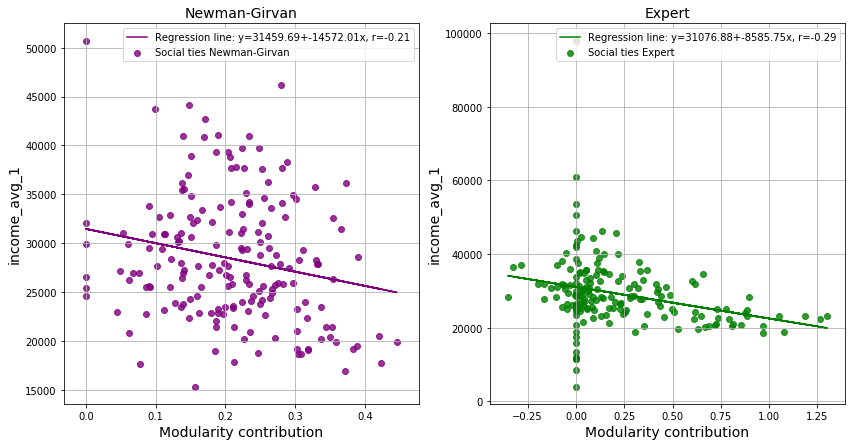

In [124]:
community_scatter_2('income_avg_1')

Regression line: y=nan+nanx, r=nan


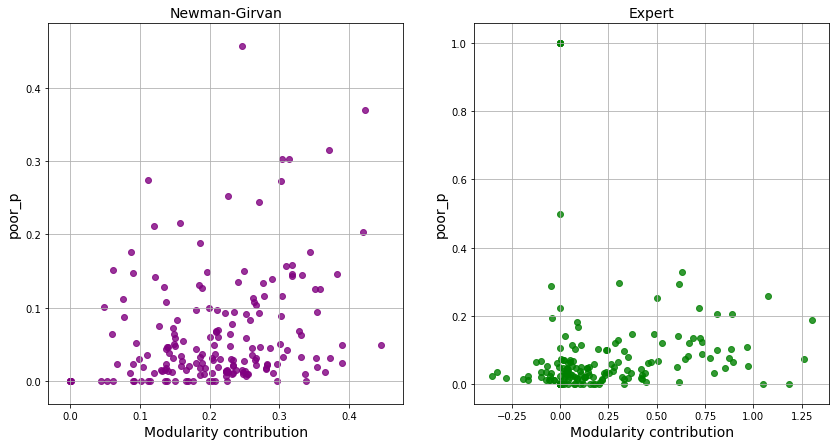

In [87]:
community_scatter_2('poor_p')

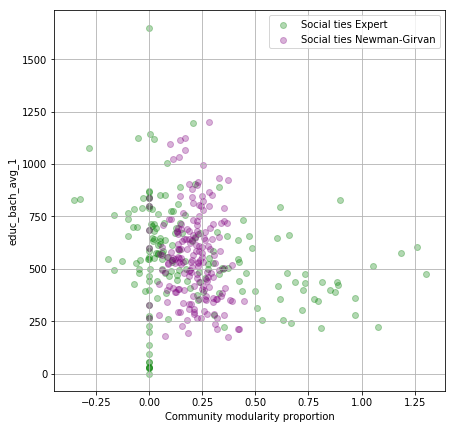

In [182]:
community_scatter('educ_bach_avg_1')

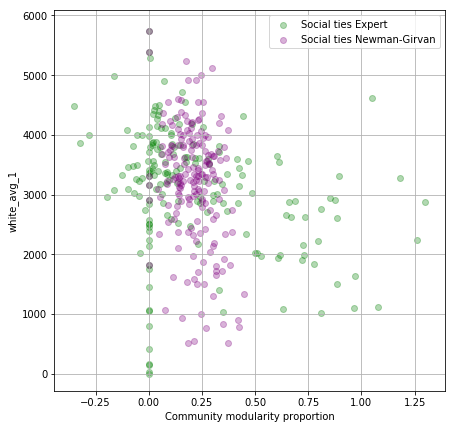

In [183]:
community_scatter('white_avg_1')

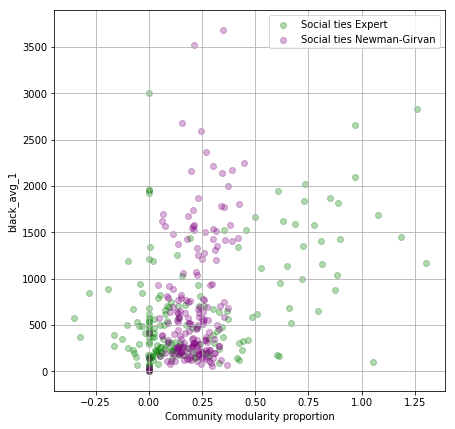

In [184]:
community_scatter('black_avg_1')

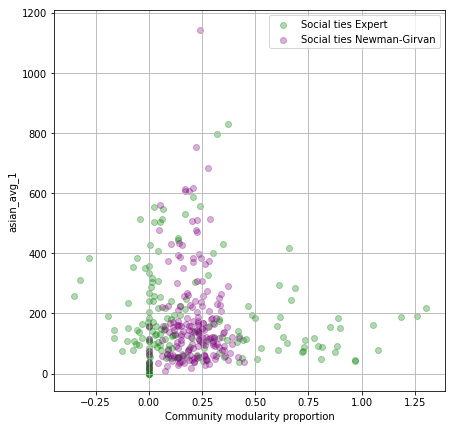

In [185]:
community_scatter('asian_avg_1')

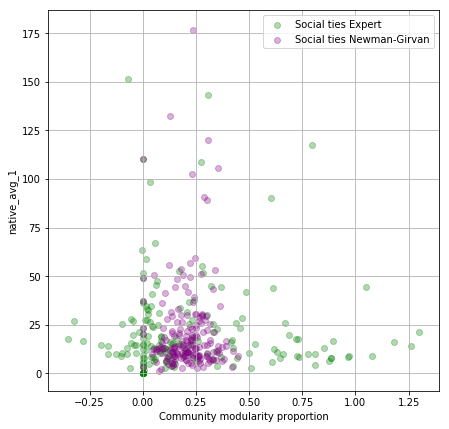

In [186]:
community_scatter('native_avg_1')

# Scatterplot with histograms

In [202]:
def scatter_hist_com(community_df, x_label, y_label, g_type):
       
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    # start with a square Figure
    fig = plt.figure(figsize=(8, 8))
    
    fig.suptitle('Communities of tracts of US metropolitans', size = 18, x = 0.42, y = 1)

    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    
    ax_histx.set_yscale('log')
    ax_histy.set_xscale('log')
    
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    
    df = community_df[community_df['g_type'] == g_type]
    
    x = df[x_label]
    y = df[y_label]

    # now determine nice limits by hand:
    ## binwidth = 0.25
    ## xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    ## lim = (int(xymax/binwidth) + 1) * binwidth
    
    
    bins_x = np.linspace(0, max(x), num = 20) # 20 bins 0 to max
    bins_y = np.linspace(0, max(y), num = 20) # 20 bins 0 to max
    #mob , _ = np.histogram(degree_mob, bins=bins)
    #fol_hh , _ = np.histogram(degree_fol_hh, bins=bins)
    #####plt.plot(bins[1:], fol_hh, label = 'Follower', marker='.', linewidth = 2, color = color_fol_hh)
    
    # colors
    colors = ['#b35806','#1b7837']#['#7f3b08',,'#00441b',',,]
    
    for (alg, color) in zip(df['algorithm_type'].unique(), colors):
        alg_df = deepcopy(df[df['algorithm_type'] == alg])
        
        # the scatter plot:
        x = alg_df[x_label]
        y = alg_df[y_label]
        
        label = 'Expert' if alg == 'ms' else 'Newman-Girwan' if alg == 'mgn' else 0
        ax.scatter(x, y, color = color, alpha = 0.5, label = label)
        ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = color) # Ellenorizni B TODO
        ax.legend(loc='lower right', fontsize = 14)
            
        
        ## bins = np.arange(-lim, lim + binwidth, binwidth)
        ax_histx.hist(x, bins=bins_x, color = color, histtype = 'stepfilled', alpha = 0.5)
        ax_histy.hist(y, bins=bins_y, color = color, histtype = 'stepfilled', orientation='horizontal', alpha = 0.5)
            
        
    if x_label == 'degree_avg':
        x_label = 'Average degree of tracts in community'
    elif x_label == 'population_avg_1':
        x_label = 'Average population of tracts in community'
    elif x_label == 'educ_bach_avg_1':
        x_label = 'Average population of tracts with BA degree in community'
    elif x_label == 'income_avg_1':
        x_label = 'Average income of tracts in community'
    elif x_label == 'white_avg_1':
        x_label = 'Average size of white population of tracts in community'
    elif x_label == 'black_avg_1':
        x_label = 'Average size of black population of tracts in community'
    elif x_label == 'native_avg_1':
        x_label = 'Average size of native population of tracts in community'
    elif x_label == 'asian_avg_1':
        x_label = 'Average size of asian population of tracts in community'

    if y_label == 'degree_avg':
        y_label = 'Average degree of tracts'
    elif y_label == 'population_avg_1':
        y_label = 'Average population of tracts'
    elif y_label == 'educ_bach_avg_1':
        y_label = 'Average population of tracts with BA degree'
    elif y_label == 'income_avg_1':
        y_label = 'Average income of tracts in community'
    elif y_label == 'white_avg_1':
        y_label = 'Average size of white population of tracts'
    elif y_label == 'black_avg_1':
        y_label = 'Average size of black population of tracts'
    elif y_label == 'native_avg_1':
        y_label = 'Average size of native population of tracts'
    elif y_label == 'asian_avg_1':
        y_label = 'Average size of asian population of tractsy'

    ax.set_xlabel(x_label, size = 14)
    ax.set_ylabel(y_label, size = 14)

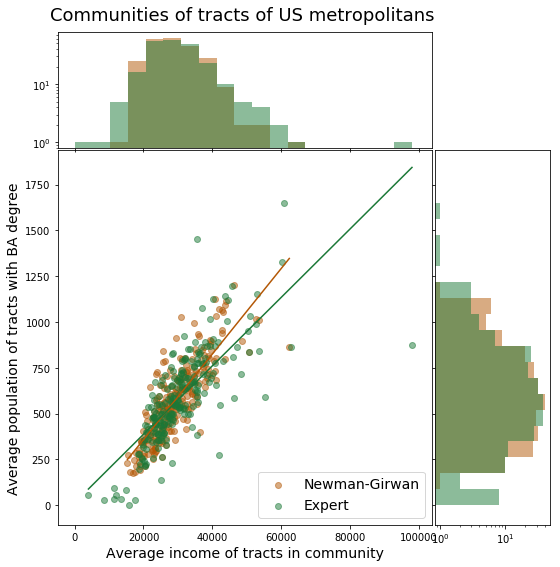

In [203]:
# use the previously defined function
# scatter_hist_com(community_df, 'income_avg_1', 'educ_bach_avg_1', 'fol_hh')

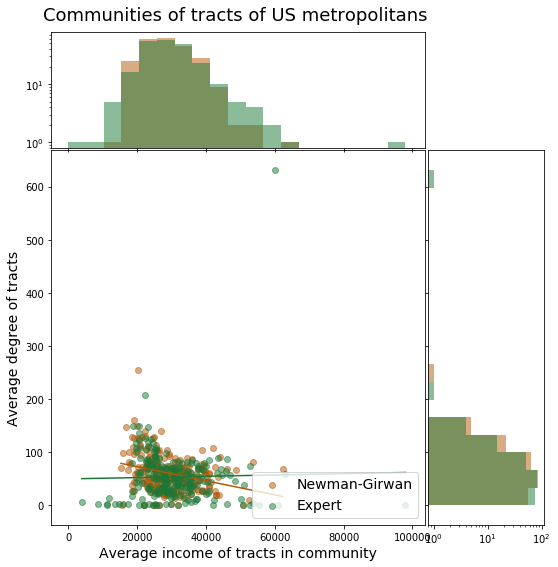

In [204]:
# scatter_hist_com(community_df, 'income_avg_1', 'degree_avg', 'fol_hh')

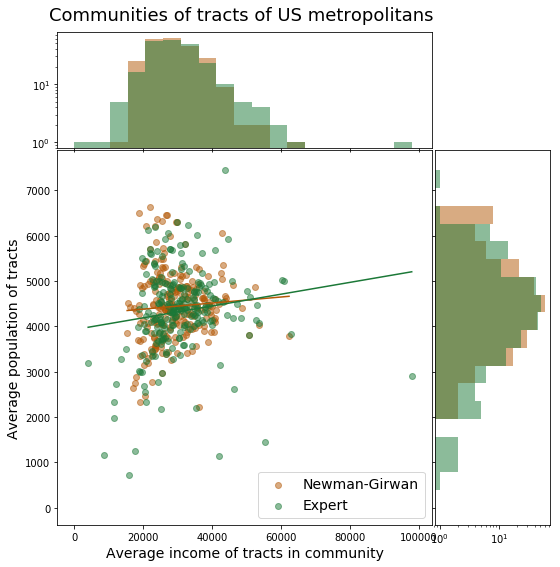

In [205]:
# scatter_hist_com(community_df, 'income_avg_1', 'population_avg_1', 'fol_hh')

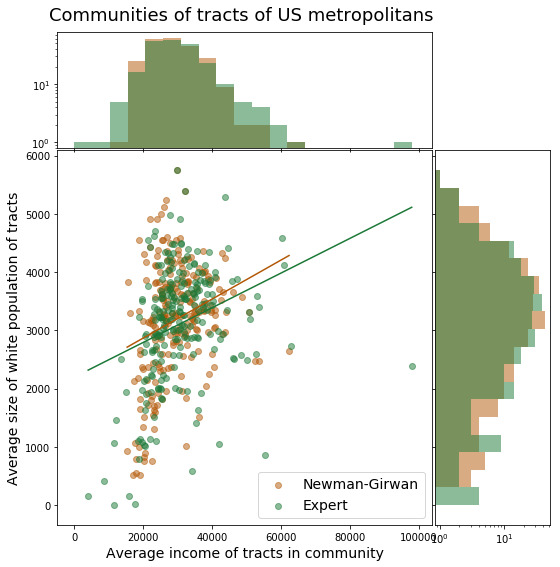

In [206]:
# scatter_hist_com(community_df, 'income_avg_1', 'white_avg_1', 'fol_hh')

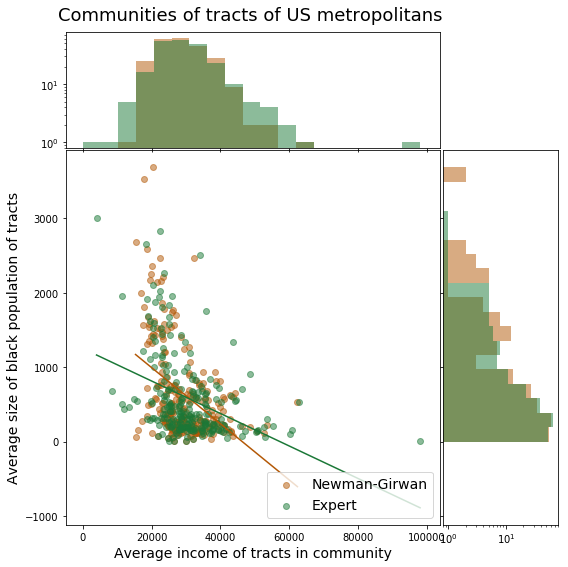

In [207]:
# scatter_hist_com(community_df, 'income_avg_1', 'black_avg_1', 'fol_hh')

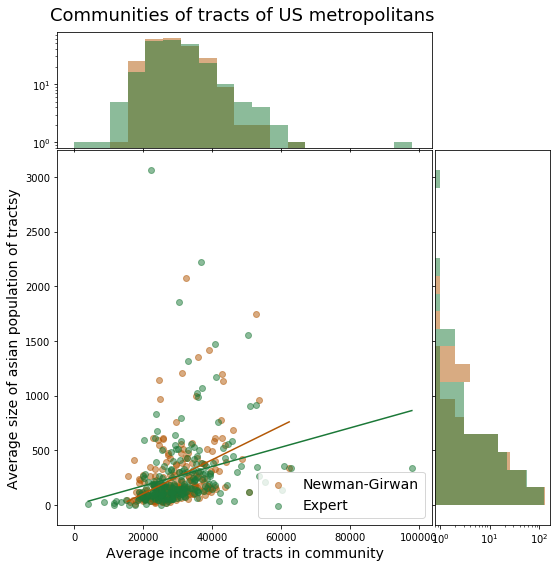

In [208]:
# scatter_hist_com(community_df, 'income_avg_1', 'asian_avg_1', 'fol_hh')

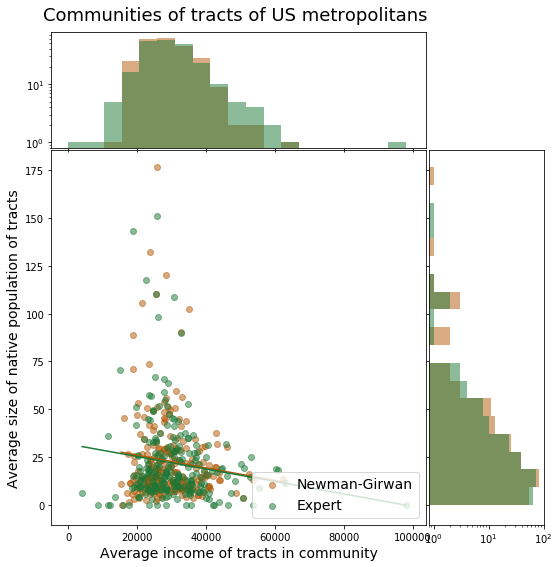

In [209]:
# scatter_hist_com(community_df, 'income_avg_1', 'native_avg_1', 'fol_hh')

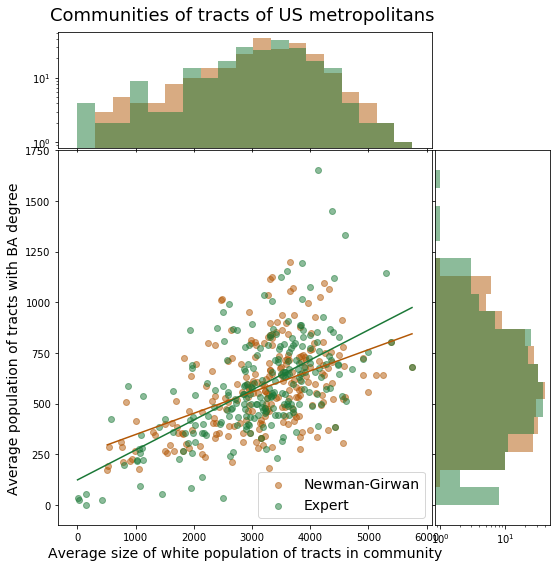

In [210]:
# scatter_hist_com(community_df, 'white_avg_1', 'educ_bach_avg_1', 'fol_hh')

/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


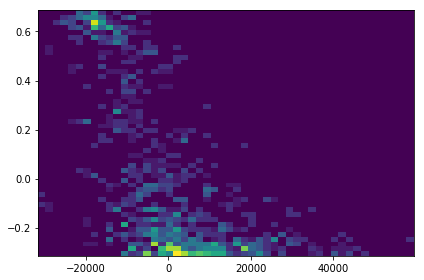

In [117]:
fig, ax = plt.subplots(tight_layout=True)
df = deepcopy(tract_df[(tract_df['city'] == 'baltimore')])
hist = ax.hist2d(df['income_diff_1'], df['black_p_diff_1'], bins = 50)

# Boxplots

In [306]:
def boxplots(tract_df, city):
    # for socail ties
    # HIBA: szinek javitani, beallitani
    fig,ax=plt.subplots(3,2, figsize=(14,13))
    fig.suptitle('Demography of communities', fontsize=20)

    df = deepcopy(tract_df[(tract_df['g_type'] == 'fol_hh') & (tract_df['city'] == city)]) #KERDES: Mikor kell deepcopy?
    df_ms = deepcopy(df[df['algorithm_type'] == 'ms'])
    df_mgn = deepcopy(df[df['algorithm_type'] == 'mgn'])

    x = 'S_cons'
    y_l = ['income_1', 'education_bachelor_1', 'white_1']
    y_title_l = ['Income', 'BA educated', 'White population']
    
    for i in list(range(len(ax))):
        y = y_l[i]
        
        data_l= [df_mgn, df_ms]
        color_l = [color_fol_hh_2, color_mob_2]
        x_title_l = ['Newman-Girvan', 'Expert']
        
        for ii in [0,1]:
        
            sns.boxplot(ax = ax[i,ii], x = x, y = y, data = data_l[ii], color = color_l[ii], showfliers = False)
            ax[i,ii].set_title(x_title_l[ii], size = 18)
            ax[i,ii].set_xlabel('')
            ax[i,ii].set_ylabel(y_title_l[i], size = 18)
            ax[i,ii].grid()

            # Calculate number of obs per group & median to position labels
            medians = data_l[ii].groupby(['S_cons'])[y].median().values
            nobs = data_l[ii]['S_cons'].value_counts().values
            nobs = [str(x) for x in nobs.tolist()]
            nobs = ["n: " + i for i in nobs]

            # Add it to the plot
            pos = range(len(nobs))
            for tick,label in zip(pos,ax[i,ii].get_xticklabels()):
                ax[i,ii].text(pos[tick],
                        medians[tick] + 0.03,
                        nobs[tick],
                        horizontalalignment='center',
                        size='medium',
                        color='black')
    plt.show()

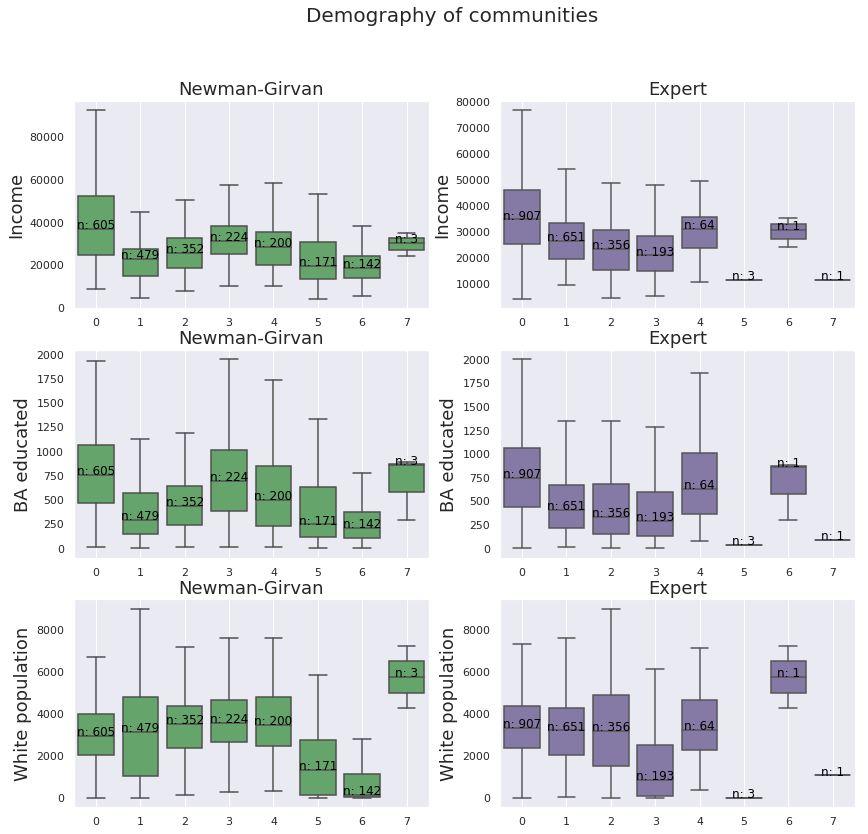

In [312]:
boxplots(tract_df, 'chicago') # KERDES: rosszul rakja fel a cimkeket - n = 1 -nek nem szabadna, hogy kiterjedese legyen

# Depreciated

In [25]:
G = create_graphs('miami', 'mob') # corresponding weighted undirected graph
        
#index_geoid_dict = dict(list(enumerate(G.nodes)))
#geoid_index_dict = dict(zip(list(index_geoid_dict.values()), list(index_geoid_dict.keys()))) KERDES: SZÜKSÉG VAN ERRE?
        
# Dataprep for Expert algorithm
A = nx.adjacency_matrix(G)
coords = np.array([tract_center_dict[n] for n in G.nodes()])
d = pdist(coords)
D = squareform(pdist(coords))
tract_outdeg_mob = mobility.groupby('tract_home')[['cnt']].sum()
N = np.matrix([tract_outdeg_mob.loc[k].iloc[0] for k in G.nodes()]).T

Ms,Mgn = SpaMod(A,D,N,200)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [86]:
# clusters to matrix format
# 1 matrix for each cluster in which 1s are for node pairs which are in the given community all others are 0s

# filter for city
city = 'miami'
algorithm_type = 'mgn'
g_type = 'mob'

S_notsorted = tract_df[(tract_df['city'] == city) & (tract_df['algorithm_type'] == algorithm_type) & (tract_df['g_type'] == g_type)].set_index('geoid')['S_cons']
S = [S_notsorted.loc[k] for k in G.nodes()] # KERDES: kell ez?

In [81]:
# numpy.dot(numpy.array([[1], [2]]), numpy.array([[3, 4]]))
com_vector = (S == 1).astype('int')
same_com = numpy.outer(com_vector, com_vector) # same community matrix (stored as array) - 0 if either node is not in community, 1 if both are in community
# MÉRET ROSSZ

In [82]:

modularity = Ms
np.multiply(np.array(modularity), same_com).sum() # add up how much more edges are present between community nodes then expected by nullmodel in the given community

1450.1622039654512

In [ ]:
# unique lists for city names
city_l = cbsacode.clean_name.unique()

tract_outdeg_mob = mobility.groupby('tract_home')[['cnt']].sum()

for city in city_l:
    for g_type in ['mob','fol_hh']:
        G = create_graphs(city, g_type) # corresponding weighted undirected graph
        
        
        # TODO --> DONE
        # index conversion dicts
        # for i,node_id in enumerate(G.nodes()):
        # for elem in enumerate(["alma","korte"]):
        #     print(elem)
        # geoid -> integer 0-... N-1
        # az elozo dict megforditottja
        # int -> geoid
        index_geoid_dict = dict(list(enumerate(G.nodes)))
        geoid_index_dict = dict(zip(list(index_geoid_dict.values()), list(index_geoid_dict.keys())))

        
        # Dataprep for Expert algorithm
        A = nx.adjacency_matrix(G)
        coords = np.array([tract_center_dict[n] for n in G.nodes()])
        d = pdist(coords)
        D = squareform(pdist(coords))
        
        # importance - number of user home in each tract
        # TODO we should check if all nodes in the follow_hh graph have an importance!
        # otherwise, the N... line is going to throw an error
        if not set(G.nodes).issubset(set(tract_outdeg_mob.reset_index().tract_home)): # test if the node is in any city KERDES : adott városra teszteljem?
            print('Error. Node(s) without importance value(s) They are dropped.') ## --> DONE
            missing_nodes = list(set(G.nodes)-set(tract_outdeg_mob.reset_index().tract_home))
            for node in missing_nodes:
                ## KERDES - ezt ki is dobjam??
                G.remove_node(node)    
        N = np.matrix([tract_outdeg_mob.loc[k].iloc[0] for k in G.nodes()]).T
        
        
        # Calculate clusterings for the given graph and write the outcome of runs to csvs
        S_ms_df = pd.DataFrame()
        S_mgn_df = pd.DataFrame()
        for _ in range(10):
            # TODO Eszter!!!! sometimes it gives an error in the first line
            # new thing: nout = 3
            Ms,Mgn = SpaMod(A,D,N,200) ### KERDES what should be the number of bins? 100?
            S_ms,Q_ms,n_it_ms = octave.iterated_genlouvain(Ms, nout=3)
            S_ms_df[len(S_ms_df.columns)] = S_ms.T[0]
            S_mgn,Q_mgn,n_it_mgn = octave.iterated_genlouvain(Mgn, nout=3)
            S_mgn_df[len(S_mgn_df.columns)] = S_mgn.T[0]

            # TODO itt egy lepesben meg lehet cisnalni mindket algorithm_type-ot!!! --> DONE
            for (algorithm_type, df) in [('ms',S_ms_df),('mgn',S_mgn_df)]:
                df['geoid'] = df.index.map(index_geoid_dict)
                # TODO --> DONE  S_df["geoid"] = S_df.index.map(a_masodik_dicted) -- kérdés: ez mit tud, amit az alatta levő sor nem?
                #S_df['geoid'] = list(G.nodes()) ## KERDES JO??? - szerintem igen (Eszter)
                df = df.set_index('geoid')
                csv_name = 'consensus_' + city + '_' + algorithm_type + '_' + g_type + '.csv'
                df.to_csv('../data/'+ csv_name)
                # TODO --> DONE mindket algorithm type-ra kimenteni a csv-t